# Reconnaissance de chiffre en language des signes avec pytorch

Dans cette exemple d'utilisation de deep learning, nous allons utiliser une base de donnée de 2061 images de mains faisant un chiffre en language des signes. Ces images sont en nuances de gris et dans une de plage de 0 à 1.
Nous disposons également des vérités terrains associés à chaque image sous forme d'un tableau de taille 10 avec un 1 à l'index de la classe correspondante.

Pour effectuer l'apprentissage nous allons utiliser pytorch.

## Chargement des images

In [11]:
#Import des modules pythons nécessaires
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
from PIL import Image
import numpy as np
import torch.utils.data as utils
from random import shuffle
import matplotlib.pyplot as plt
#Affichage de la graine d'aléatoire actuelle (afin de reproduire des résultats si nécessaire)
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#Chargement de cuda
device = torch.device("cuda:0")

Random Seed:  1042


Avant d'aller plus en profondeur avec des réseaux de neurone il faut tout d'abord charger les données.
Pour cela nous chargons directement les images via numpy et pour et les vérités terrains nous avons décider de ramener le tableau à 1 unique valeur représentant l'axe.

<PIL.Image.Image image mode=L size=32x32 at 0x7FD93BA115C0>
Classes :  0.0


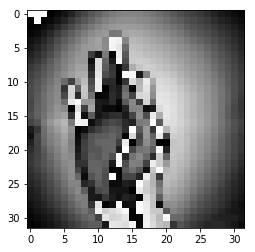

In [12]:
#Chargement des images
#L'image est d'abord redimmensionnée
#Puis noramlisé entre -0.5 et 0.5
Trans = transforms.Compose([
            transforms.Resize(32),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,)),
        ])
images = [Trans(Image.fromarray(im)) for im in np.load("./datas/X.npy")]
#Chargement des classes
temp = np.load("./datas/Y.npy")
classes = np.zeros(len(images))
for i in range(len(classes)):
    classes[i] = temp[i].nonzero()[0][0]
plt.imshow(transforms.ToPILImage()(images[0]))
print(transforms.ToPILImage()(images[0]))
print("Classes : ",classes[0])

Pour avoir des datasets cohérents il faut aussi mélanger les données de bases

In [13]:
#Mélange du dataset
temp_s = []
for i in range(len(classes)):
    temp_s.append([images[i],classes[i] ])
shuffle(temp_s)
for i in range(len(classes)):
    [im,c] = temp_s[i]
    images[i] = im
    classes[i] = c

Maintenant que nous avons nore dataset il faut le partitionner pour avoir un ensemble pour l'entraînement
et un pour les tests (afin de vérifier que notre réseau n'apprend pas par coeur)

In [14]:
#Définition des partitions du dataset
#Nous choisissons de prendre un dataset d'entrainement représentant 80% des données
prc_train = int(0.80*len(images))
prc_test = prc_train + int(0.2*len(images))
#Chargement des partitions
def load():
    out = []
    prc = [prc_train,prc_test]
    for i in range(len(prc)):
        if i == 0:
            images_train = [(im) for im in images[:prc[i]]]
            classes_train = classes[:prc_train]
        #elif i == len(prc)-1:
        #    images_train = [(im) for im in images[prc[i]:]]
        #    classes_train = classes[prc[i]:]
        else:
            images_train = [(im) for im  in images[prc[i-1]:prc[i]]]
            classes_train = classes[prc_train:prc_test]
        tensor_x_train = torch.stack([torch.Tensor(i) for i in images_train])
        tensor_y_train = torch.from_numpy(classes_train).long()
        datas_train = utils.TensorDataset(tensor_x_train,tensor_y_train)
        dataloader_train = utils.DataLoader(datas_train,50, shuffle=True)
        out.append(dataloader_train)
    return out
[dataloader_train,dataloader_test] = load()

Ensuite il faut définir les fonctions d'entraînements et de test associé pour entraîner nos réseaux

In [15]:
def train(model, dataloader_train, optimizer, epoch, criterion):
    model.train()
    sum_loss = 0
    for i, (data,target) in enumerate(dataloader_train, 0):
        data, target = data.to(device), target.to(device)
        #print(target)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        #print(output)
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()
        if i % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(data), len(dataloader_train.dataset),
                100. * i / len(dataloader_train), loss.item()))
        return loss.item()
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for i, (data,target) in enumerate(test_loader, 0):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return test_loss, 100. * correct / len(test_loader.dataset)

## Réseau full connected

Maintenant nous pouvons passer à la définition de notre réseau, nous allons tout d'abord commencer avec un perceptron multicouche.

In [16]:
class Net_FC(nn.Module):
    def __init__(self):
        super(Net_FC, self).__init__()
        self.fc1 = nn.Linear(32*32,200)
        self.fc2 = nn.Linear(200, 10)

    def forward(self, x):
        x = x.view(-1,32*32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(x, dim=1)
criterion = nn.NLLLoss()
model = Net_FC().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

Il est maintenant temps de lancer notre premier apprentissage et voir les résultats

Train Epoch: 0 [0/1649 (0%)]	Loss: 2.303326

Test set: Average loss: 2.3267, Accuracy: 57/412 (14%)

Train Epoch: 1 [0/1649 (0%)]	Loss: 2.253472

Test set: Average loss: 2.3496, Accuracy: 45/412 (11%)

Train Epoch: 2 [0/1649 (0%)]	Loss: 2.280328

Test set: Average loss: 2.2265, Accuracy: 89/412 (22%)

Train Epoch: 3 [0/1649 (0%)]	Loss: 2.224065

Test set: Average loss: 2.1955, Accuracy: 87/412 (21%)

Train Epoch: 4 [0/1649 (0%)]	Loss: 2.215297

Test set: Average loss: 2.2254, Accuracy: 64/412 (16%)

Train Epoch: 5 [0/1649 (0%)]	Loss: 2.294441

Test set: Average loss: 2.1721, Accuracy: 89/412 (22%)

Train Epoch: 6 [0/1649 (0%)]	Loss: 2.155055

Test set: Average loss: 2.1566, Accuracy: 98/412 (24%)

Train Epoch: 7 [0/1649 (0%)]	Loss: 2.196112

Test set: Average loss: 2.1388, Accuracy: 96/412 (23%)

Train Epoch: 8 [0/1649 (0%)]	Loss: 2.089194

Test set: Average loss: 2.1060, Accuracy: 85/412 (21%)

Train Epoch: 9 [0/1649 (0%)]	Loss: 2.059728

Test set: Average loss: 2.0962, Accuracy: 83/4


Test set: Average loss: 1.9185, Accuracy: 112/412 (27%)

Train Epoch: 84 [0/1649 (0%)]	Loss: 1.831355

Test set: Average loss: 1.9091, Accuracy: 111/412 (27%)

Train Epoch: 85 [0/1649 (0%)]	Loss: 2.030544

Test set: Average loss: 1.9074, Accuracy: 111/412 (27%)

Train Epoch: 86 [0/1649 (0%)]	Loss: 2.009948

Test set: Average loss: 1.9057, Accuracy: 114/412 (28%)

Train Epoch: 87 [0/1649 (0%)]	Loss: 1.871239

Test set: Average loss: 1.9218, Accuracy: 113/412 (27%)

Train Epoch: 88 [0/1649 (0%)]	Loss: 1.795794

Test set: Average loss: 1.9520, Accuracy: 110/412 (27%)

Train Epoch: 89 [0/1649 (0%)]	Loss: 2.038154

Test set: Average loss: 1.9660, Accuracy: 111/412 (27%)

Train Epoch: 90 [0/1649 (0%)]	Loss: 2.220897

Test set: Average loss: 1.9562, Accuracy: 110/412 (27%)

Train Epoch: 91 [0/1649 (0%)]	Loss: 1.976546

Test set: Average loss: 1.9322, Accuracy: 110/412 (27%)

Train Epoch: 92 [0/1649 (0%)]	Loss: 1.825426

Test set: Average loss: 1.9206, Accuracy: 111/412 (27%)

Train Epoch: 93


Test set: Average loss: 1.8354, Accuracy: 135/412 (33%)

Train Epoch: 168 [0/1649 (0%)]	Loss: 1.806566

Test set: Average loss: 1.8442, Accuracy: 128/412 (31%)

Train Epoch: 169 [0/1649 (0%)]	Loss: 1.773153

Test set: Average loss: 1.9269, Accuracy: 115/412 (28%)

Train Epoch: 170 [0/1649 (0%)]	Loss: 1.794892

Test set: Average loss: 1.9260, Accuracy: 114/412 (28%)

Train Epoch: 171 [0/1649 (0%)]	Loss: 1.964898

Test set: Average loss: 1.8614, Accuracy: 128/412 (31%)

Train Epoch: 172 [0/1649 (0%)]	Loss: 1.784596

Test set: Average loss: 1.8943, Accuracy: 130/412 (32%)

Train Epoch: 173 [0/1649 (0%)]	Loss: 1.990551

Test set: Average loss: 1.8959, Accuracy: 130/412 (32%)

Train Epoch: 174 [0/1649 (0%)]	Loss: 2.056072

Test set: Average loss: 1.8608, Accuracy: 133/412 (32%)

Train Epoch: 175 [0/1649 (0%)]	Loss: 1.691118

Test set: Average loss: 1.8293, Accuracy: 135/412 (33%)

Train Epoch: 176 [0/1649 (0%)]	Loss: 1.795705

Test set: Average loss: 1.8003, Accuracy: 135/412 (33%)

Train 


Test set: Average loss: 1.6710, Accuracy: 168/412 (41%)

Train Epoch: 259 [0/1649 (0%)]	Loss: 1.626900

Test set: Average loss: 1.6804, Accuracy: 164/412 (40%)

Train Epoch: 260 [0/1649 (0%)]	Loss: 1.583133

Test set: Average loss: 1.6807, Accuracy: 164/412 (40%)

Train Epoch: 261 [0/1649 (0%)]	Loss: 1.238073

Test set: Average loss: 1.6766, Accuracy: 164/412 (40%)

Train Epoch: 262 [0/1649 (0%)]	Loss: 1.658435

Test set: Average loss: 1.6853, Accuracy: 160/412 (39%)

Train Epoch: 263 [0/1649 (0%)]	Loss: 1.587376

Test set: Average loss: 1.6561, Accuracy: 165/412 (40%)

Train Epoch: 264 [0/1649 (0%)]	Loss: 1.813581

Test set: Average loss: 1.6413, Accuracy: 166/412 (40%)

Train Epoch: 265 [0/1649 (0%)]	Loss: 1.589782

Test set: Average loss: 1.6328, Accuracy: 166/412 (40%)

Train Epoch: 266 [0/1649 (0%)]	Loss: 1.633115

Test set: Average loss: 1.6293, Accuracy: 166/412 (40%)

Train Epoch: 267 [0/1649 (0%)]	Loss: 1.835959

Test set: Average loss: 1.6311, Accuracy: 170/412 (41%)

Train 

Train Epoch: 342 [0/1649 (0%)]	Loss: 1.489168

Test set: Average loss: 1.6422, Accuracy: 164/412 (40%)

Train Epoch: 343 [0/1649 (0%)]	Loss: 1.641879

Test set: Average loss: 1.6181, Accuracy: 168/412 (41%)

Train Epoch: 344 [0/1649 (0%)]	Loss: 1.591333

Test set: Average loss: 1.6027, Accuracy: 168/412 (41%)

Train Epoch: 345 [0/1649 (0%)]	Loss: 1.722479

Test set: Average loss: 1.6010, Accuracy: 168/412 (41%)

Train Epoch: 346 [0/1649 (0%)]	Loss: 1.360886

Test set: Average loss: 1.6061, Accuracy: 168/412 (41%)

Train Epoch: 347 [0/1649 (0%)]	Loss: 1.450205

Test set: Average loss: 1.6029, Accuracy: 167/412 (41%)

Train Epoch: 348 [0/1649 (0%)]	Loss: 1.737765

Test set: Average loss: 1.6053, Accuracy: 168/412 (41%)

Train Epoch: 349 [0/1649 (0%)]	Loss: 1.705074

Test set: Average loss: 1.6126, Accuracy: 169/412 (41%)

Train Epoch: 350 [0/1649 (0%)]	Loss: 1.461811

Test set: Average loss: 1.6145, Accuracy: 169/412 (41%)

Train Epoch: 351 [0/1649 (0%)]	Loss: 1.620768

Test set: Average


Test set: Average loss: 1.6241, Accuracy: 167/412 (41%)

Train Epoch: 432 [0/1649 (0%)]	Loss: 1.691857

Test set: Average loss: 1.6141, Accuracy: 167/412 (41%)

Train Epoch: 433 [0/1649 (0%)]	Loss: 1.494244

Test set: Average loss: 1.6088, Accuracy: 166/412 (40%)

Train Epoch: 434 [0/1649 (0%)]	Loss: 1.475935

Test set: Average loss: 1.6116, Accuracy: 164/412 (40%)

Train Epoch: 435 [0/1649 (0%)]	Loss: 1.488417

Test set: Average loss: 1.6147, Accuracy: 164/412 (40%)

Train Epoch: 436 [0/1649 (0%)]	Loss: 1.540918

Test set: Average loss: 1.6215, Accuracy: 164/412 (40%)

Train Epoch: 437 [0/1649 (0%)]	Loss: 1.638036

Test set: Average loss: 1.6199, Accuracy: 167/412 (41%)

Train Epoch: 438 [0/1649 (0%)]	Loss: 1.456524

Test set: Average loss: 1.6254, Accuracy: 166/412 (40%)

Train Epoch: 439 [0/1649 (0%)]	Loss: 1.679954

Test set: Average loss: 1.6227, Accuracy: 167/412 (41%)

Train Epoch: 440 [0/1649 (0%)]	Loss: 1.651738

Test set: Average loss: 1.6257, Accuracy: 169/412 (41%)

Train 

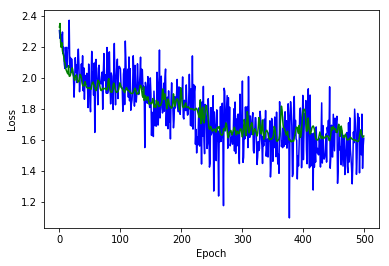

In [17]:
epoch_arr = range(500)
train_loss = []
test_loss = []
max_test = 0

#Entrainement
for epoch in epoch_arr:
    train_loss.append( train(model, dataloader_train, optimizer, epoch, F.nll_loss))
    loss,test_prc = test(model, dataloader_test)
    if test_prc > max_test:
        max_test = test_prc
        torch.save(model.state_dict(), './best.pth')
    test_loss.append( loss )
print("max acc : ",max_test)
print("Used Seed: ", manualSeed)
#Affichage des courbes de loss
plt.plot(epoch_arr,train_loss,'b')
plt.plot(epoch_arr,test_loss,'g')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

Les résultats sont très peu concluant, on peut maintenant esasyer avec un réseau à convolution que l'on termine avec 2 couches full connected.

## Réseau à convolution

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, 1)
        self.conv2 = nn.Conv2d(64, 128, 5, 1)
        self.fc1 = nn.Linear(5*5*128, 1000)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        x= self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 5*5*128)#Modification de la forme des donneés pour les faire rentrer dans les couches full connected
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training) #Utilisation de dropout pour ajouter de l'aléatoire à l'entraienement
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
criterion = nn.NLLLoss()
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)

Train Epoch: 0 [0/1649 (0%)]	Loss: 2.302971

Test set: Average loss: 5.0488, Accuracy: 56/412 (14%)

Train Epoch: 1 [0/1649 (0%)]	Loss: 5.151642

Test set: Average loss: 2.5290, Accuracy: 45/412 (11%)

Train Epoch: 2 [0/1649 (0%)]	Loss: 2.584954

Test set: Average loss: 2.3014, Accuracy: 43/412 (10%)

Train Epoch: 3 [0/1649 (0%)]	Loss: 2.297661

Test set: Average loss: 2.2974, Accuracy: 43/412 (10%)

Train Epoch: 4 [0/1649 (0%)]	Loss: 2.317924

Test set: Average loss: 2.2946, Accuracy: 56/412 (14%)

Train Epoch: 5 [0/1649 (0%)]	Loss: 2.295610

Test set: Average loss: 2.2911, Accuracy: 50/412 (12%)

Train Epoch: 6 [0/1649 (0%)]	Loss: 2.290485

Test set: Average loss: 2.2846, Accuracy: 39/412 (9%)

Train Epoch: 7 [0/1649 (0%)]	Loss: 2.299479

Test set: Average loss: 2.2782, Accuracy: 39/412 (9%)

Train Epoch: 8 [0/1649 (0%)]	Loss: 2.277762

Test set: Average loss: 2.2705, Accuracy: 68/412 (17%)

Train Epoch: 9 [0/1649 (0%)]	Loss: 2.279187

Test set: Average loss: 2.2572, Accuracy: 85/412

Train Epoch: 80 [0/1649 (0%)]	Loss: 0.335649

Test set: Average loss: 0.4573, Accuracy: 348/412 (84%)

Train Epoch: 81 [0/1649 (0%)]	Loss: 0.225585

Test set: Average loss: 0.4873, Accuracy: 342/412 (83%)

Train Epoch: 82 [0/1649 (0%)]	Loss: 0.582461

Test set: Average loss: 0.5300, Accuracy: 342/412 (83%)

Train Epoch: 83 [0/1649 (0%)]	Loss: 0.376702

Test set: Average loss: 0.5120, Accuracy: 344/412 (83%)

Train Epoch: 84 [0/1649 (0%)]	Loss: 0.824355

Test set: Average loss: 0.4999, Accuracy: 347/412 (84%)

Train Epoch: 85 [0/1649 (0%)]	Loss: 0.539483

Test set: Average loss: 0.4803, Accuracy: 348/412 (84%)

Train Epoch: 86 [0/1649 (0%)]	Loss: 0.373666

Test set: Average loss: 0.5102, Accuracy: 341/412 (83%)

Train Epoch: 87 [0/1649 (0%)]	Loss: 0.382459

Test set: Average loss: 0.5325, Accuracy: 338/412 (82%)

Train Epoch: 88 [0/1649 (0%)]	Loss: 0.548779

Test set: Average loss: 0.5207, Accuracy: 341/412 (83%)

Train Epoch: 89 [0/1649 (0%)]	Loss: 0.422551

Test set: Average loss: 0.5

Train Epoch: 160 [0/1649 (0%)]	Loss: 0.125561

Test set: Average loss: 0.2786, Accuracy: 374/412 (91%)

Train Epoch: 161 [0/1649 (0%)]	Loss: 0.087325

Test set: Average loss: 0.2879, Accuracy: 374/412 (91%)

Train Epoch: 162 [0/1649 (0%)]	Loss: 0.380334

Test set: Average loss: 0.2944, Accuracy: 374/412 (91%)

Train Epoch: 163 [0/1649 (0%)]	Loss: 0.178270

Test set: Average loss: 0.2953, Accuracy: 374/412 (91%)

Train Epoch: 164 [0/1649 (0%)]	Loss: 0.261934

Test set: Average loss: 0.2978, Accuracy: 375/412 (91%)

Train Epoch: 165 [0/1649 (0%)]	Loss: 0.089837

Test set: Average loss: 0.3008, Accuracy: 375/412 (91%)

Train Epoch: 166 [0/1649 (0%)]	Loss: 0.108098

Test set: Average loss: 0.3211, Accuracy: 367/412 (89%)

Train Epoch: 167 [0/1649 (0%)]	Loss: 0.244097

Test set: Average loss: 0.3152, Accuracy: 372/412 (90%)

Train Epoch: 168 [0/1649 (0%)]	Loss: 0.254445

Test set: Average loss: 0.2989, Accuracy: 371/412 (90%)

Train Epoch: 169 [0/1649 (0%)]	Loss: 0.273631

Test set: Average


Test set: Average loss: 0.3045, Accuracy: 367/412 (89%)

Train Epoch: 244 [0/1649 (0%)]	Loss: 0.075156

Test set: Average loss: 0.2826, Accuracy: 366/412 (89%)

Train Epoch: 245 [0/1649 (0%)]	Loss: 0.132574

Test set: Average loss: 0.2692, Accuracy: 370/412 (90%)

Train Epoch: 246 [0/1649 (0%)]	Loss: 0.081038

Test set: Average loss: 0.2626, Accuracy: 373/412 (91%)

Train Epoch: 247 [0/1649 (0%)]	Loss: 0.126541

Test set: Average loss: 0.2589, Accuracy: 374/412 (91%)

Train Epoch: 248 [0/1649 (0%)]	Loss: 0.086021

Test set: Average loss: 0.2609, Accuracy: 378/412 (92%)

Train Epoch: 249 [0/1649 (0%)]	Loss: 0.178066

Test set: Average loss: 0.2662, Accuracy: 378/412 (92%)

Train Epoch: 250 [0/1649 (0%)]	Loss: 0.078716

Test set: Average loss: 0.2780, Accuracy: 377/412 (92%)

Train Epoch: 251 [0/1649 (0%)]	Loss: 0.080267

Test set: Average loss: 0.2989, Accuracy: 375/412 (91%)

Train Epoch: 252 [0/1649 (0%)]	Loss: 0.080593

Test set: Average loss: 0.3116, Accuracy: 376/412 (91%)

Train 


Test set: Average loss: 0.2246, Accuracy: 377/412 (92%)

Train Epoch: 323 [0/1649 (0%)]	Loss: 0.070761

Test set: Average loss: 0.2049, Accuracy: 375/412 (91%)

Train Epoch: 324 [0/1649 (0%)]	Loss: 0.154988

Test set: Average loss: 0.2048, Accuracy: 379/412 (92%)

Train Epoch: 325 [0/1649 (0%)]	Loss: 0.022654

Test set: Average loss: 0.2128, Accuracy: 379/412 (92%)

Train Epoch: 326 [0/1649 (0%)]	Loss: 0.279982

Test set: Average loss: 0.2256, Accuracy: 376/412 (91%)

Train Epoch: 327 [0/1649 (0%)]	Loss: 0.112595

Test set: Average loss: 0.2307, Accuracy: 375/412 (91%)

Train Epoch: 328 [0/1649 (0%)]	Loss: 0.038956

Test set: Average loss: 0.2342, Accuracy: 375/412 (91%)

Train Epoch: 329 [0/1649 (0%)]	Loss: 0.042661

Test set: Average loss: 0.2366, Accuracy: 375/412 (91%)

Train Epoch: 330 [0/1649 (0%)]	Loss: 0.069711

Test set: Average loss: 0.2328, Accuracy: 377/412 (92%)

Train Epoch: 331 [0/1649 (0%)]	Loss: 0.066113

Test set: Average loss: 0.2330, Accuracy: 379/412 (92%)

Train 


Test set: Average loss: 0.2489, Accuracy: 376/412 (91%)

Train Epoch: 403 [0/1649 (0%)]	Loss: 0.072415

Test set: Average loss: 0.2460, Accuracy: 381/412 (92%)

Train Epoch: 404 [0/1649 (0%)]	Loss: 0.057969

Test set: Average loss: 0.2454, Accuracy: 383/412 (93%)

Train Epoch: 405 [0/1649 (0%)]	Loss: 0.135727

Test set: Average loss: 0.2521, Accuracy: 380/412 (92%)

Train Epoch: 406 [0/1649 (0%)]	Loss: 0.040497

Test set: Average loss: 0.2647, Accuracy: 379/412 (92%)

Train Epoch: 407 [0/1649 (0%)]	Loss: 0.029439

Test set: Average loss: 0.2808, Accuracy: 378/412 (92%)

Train Epoch: 408 [0/1649 (0%)]	Loss: 0.069212

Test set: Average loss: 0.2807, Accuracy: 377/412 (92%)

Train Epoch: 409 [0/1649 (0%)]	Loss: 0.055118

Test set: Average loss: 0.2726, Accuracy: 376/412 (91%)

Train Epoch: 410 [0/1649 (0%)]	Loss: 0.221478

Test set: Average loss: 0.2705, Accuracy: 379/412 (92%)

Train Epoch: 411 [0/1649 (0%)]	Loss: 0.109376

Test set: Average loss: 0.2772, Accuracy: 377/412 (92%)

Train 


Test set: Average loss: 0.2860, Accuracy: 379/412 (92%)

Train Epoch: 484 [0/1649 (0%)]	Loss: 0.004580

Test set: Average loss: 0.2820, Accuracy: 379/412 (92%)

Train Epoch: 485 [0/1649 (0%)]	Loss: 0.012084

Test set: Average loss: 0.2792, Accuracy: 379/412 (92%)

Train Epoch: 486 [0/1649 (0%)]	Loss: 0.018104

Test set: Average loss: 0.2745, Accuracy: 379/412 (92%)

Train Epoch: 487 [0/1649 (0%)]	Loss: 0.025429

Test set: Average loss: 0.2718, Accuracy: 383/412 (93%)

Train Epoch: 488 [0/1649 (0%)]	Loss: 0.024925

Test set: Average loss: 0.2709, Accuracy: 382/412 (93%)

Train Epoch: 489 [0/1649 (0%)]	Loss: 0.017974

Test set: Average loss: 0.2752, Accuracy: 384/412 (93%)

Train Epoch: 490 [0/1649 (0%)]	Loss: 0.005192

Test set: Average loss: 0.2820, Accuracy: 382/412 (93%)

Train Epoch: 491 [0/1649 (0%)]	Loss: 0.017328

Test set: Average loss: 0.2883, Accuracy: 381/412 (92%)

Train Epoch: 492 [0/1649 (0%)]	Loss: 0.174694

Test set: Average loss: 0.2717, Accuracy: 383/412 (93%)

Train 

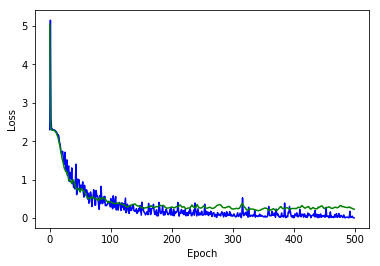

In [19]:
epoch_arr = range(500)
train_loss = []
test_loss = []
max_test = 0

#Entrainement
for epoch in epoch_arr:
    train_loss.append( train(model, dataloader_train, optimizer, epoch, F.nll_loss))
    loss,test_prc = test(model, dataloader_test)
    if test_prc > max_test:
        max_test = test_prc
        torch.save(model.state_dict(), './best.pth')
    test_loss.append( loss )
print("max acc : ",max_test)
print("Used Seed: ", manualSeed)
#Affichage des courbes de loss
plt.plot(epoch_arr,train_loss,'b')
plt.plot(epoch_arr,test_loss,'g')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

## Réseau residuel

Ici les résultats sont bien meilleurs pouvant atteindre les 95%.

Mais il est possible d'aller encore plus loin avec des architectures bien plus complexes.
Pour cette expérimentation nous allons essayer de construire une architecture de type ResNet (pour Residual Network).
Le principe est simple, après chaque convolution il y a une perte de l'information d'origine, ainsi pour pouvoir conserver ces informations lors du traitement il suffit de sauvegarder les données avant un ensemble de convolution, puis de venir les ajouter à la fin d'un ensemble de convolution. Ce type de d'opération s'appel un block résiduel, dans notre cas nous allons construire des blocks de 2 convolution 3*3, et pour venir injecter les données nous allons simplement faire la somme après la 2ème convolution.
Nous allons également utiliser des batchnorms entre chaque convolution pour améliorer les performances du réseau.
Ensuite notre réseau final sera constitué 4 bloc résiduel suivit de 2 couches full connected pour ramener l'informations à un ensemble traitable.

In [21]:
def conv3x3(in_planes, out_planes, stride=1):
    """Convolution 3*3 conservant la taille initiale de l'image en utilsant un padding de 1"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
padding=1, bias=False)

class ResBlock(nn.Module):
    """Définition d'un bloc résiduel"""
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        #Ajoute une couche supplémentaire pour redimenssioner le résidu si il ne possède pas la même
        #forme que la sortie des convolutions
        if inplanes != planes:
            self.downsample = nn.Sequential(nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes))
        else:
            self.downsample = None
        self.stride = stride

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Net_RES_32(nn.Module):
    def __init__(self):
        super(Net_RES_32, self).__init__()
        self.b1 = ResBlock(1,32)
        self.b2 = ResBlock(32,32)
        self.b3 = ResBlock(32,64)
        self.b4 = ResBlock(64,128)
        self.fc1 = nn.Linear(64*4*4, 300)
        #self.fc1_b = nn.Linear(800, 200)
        self.fc2 = nn.Linear(300, 10)

    def forward(self, x):
        x = self.b1(x)
        x = F.max_pool2d(x,2)

        x = self.b2(x)
        x = F.max_pool2d(x,2)

        x = self.b3(x)
        x = F.max_pool2d(x,2)
        #x = self.b4(x)
        #x = F.max_pool2d(x,2)

        x = x.view(-1,x.shape[1]*x.shape[2]*x.shape[3])
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc1_b(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
criterion = nn.NLLLoss()
model = Net_RES_32().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)


Ce réseau étant bien plus complexe que les précédent nous allons l'entraîner jusqu'à 1000 epoch.

Train Epoch: 0 [0/1649 (0%)]	Loss: 2.358273

Test set: Average loss: 2.3055, Accuracy: 34/412 (8%)

Train Epoch: 1 [0/1649 (0%)]	Loss: 2.836824

Test set: Average loss: 2.3018, Accuracy: 37/412 (9%)

Train Epoch: 2 [0/1649 (0%)]	Loss: 2.729532

Test set: Average loss: 2.3027, Accuracy: 47/412 (11%)

Train Epoch: 3 [0/1649 (0%)]	Loss: 2.281057

Test set: Average loss: 2.3047, Accuracy: 38/412 (9%)

Train Epoch: 4 [0/1649 (0%)]	Loss: 2.315024

Test set: Average loss: 2.3049, Accuracy: 38/412 (9%)

Train Epoch: 5 [0/1649 (0%)]	Loss: 2.270632

Test set: Average loss: 2.3005, Accuracy: 38/412 (9%)

Train Epoch: 6 [0/1649 (0%)]	Loss: 2.126606

Test set: Average loss: 2.2947, Accuracy: 67/412 (16%)

Train Epoch: 7 [0/1649 (0%)]	Loss: 1.897759

Test set: Average loss: 2.2915, Accuracy: 62/412 (15%)

Train Epoch: 8 [0/1649 (0%)]	Loss: 1.829829

Test set: Average loss: 2.2898, Accuracy: 68/412 (17%)

Train Epoch: 9 [0/1649 (0%)]	Loss: 1.759290

Test set: Average loss: 2.2868, Accuracy: 88/412 (2


Test set: Average loss: 0.1898, Accuracy: 389/412 (94%)

Train Epoch: 83 [0/1649 (0%)]	Loss: 0.045619

Test set: Average loss: 0.2321, Accuracy: 382/412 (93%)

Train Epoch: 84 [0/1649 (0%)]	Loss: 0.168882

Test set: Average loss: 0.2750, Accuracy: 373/412 (91%)

Train Epoch: 85 [0/1649 (0%)]	Loss: 0.196899

Test set: Average loss: 0.2224, Accuracy: 382/412 (93%)

Train Epoch: 86 [0/1649 (0%)]	Loss: 0.213616

Test set: Average loss: 0.1885, Accuracy: 388/412 (94%)

Train Epoch: 87 [0/1649 (0%)]	Loss: 0.159544

Test set: Average loss: 0.1690, Accuracy: 388/412 (94%)

Train Epoch: 88 [0/1649 (0%)]	Loss: 0.137084

Test set: Average loss: 0.2163, Accuracy: 381/412 (92%)

Train Epoch: 89 [0/1649 (0%)]	Loss: 0.084049

Test set: Average loss: 0.2863, Accuracy: 369/412 (90%)

Train Epoch: 90 [0/1649 (0%)]	Loss: 0.120719

Test set: Average loss: 0.3317, Accuracy: 363/412 (88%)

Train Epoch: 91 [0/1649 (0%)]	Loss: 0.247080

Test set: Average loss: 0.3173, Accuracy: 365/412 (89%)

Train Epoch: 92


Test set: Average loss: 0.0885, Accuracy: 401/412 (97%)

Train Epoch: 162 [0/1649 (0%)]	Loss: 0.223296

Test set: Average loss: 0.0862, Accuracy: 401/412 (97%)

Train Epoch: 163 [0/1649 (0%)]	Loss: 0.064244

Test set: Average loss: 0.0852, Accuracy: 401/412 (97%)

Train Epoch: 164 [0/1649 (0%)]	Loss: 0.116478

Test set: Average loss: 0.0837, Accuracy: 401/412 (97%)

Train Epoch: 165 [0/1649 (0%)]	Loss: 0.093019

Test set: Average loss: 0.0842, Accuracy: 401/412 (97%)

Train Epoch: 166 [0/1649 (0%)]	Loss: 0.026518

Test set: Average loss: 0.0892, Accuracy: 400/412 (97%)

Train Epoch: 167 [0/1649 (0%)]	Loss: 0.071791

Test set: Average loss: 0.0771, Accuracy: 402/412 (98%)

Train Epoch: 168 [0/1649 (0%)]	Loss: 0.053593

Test set: Average loss: 0.0719, Accuracy: 402/412 (98%)

Train Epoch: 169 [0/1649 (0%)]	Loss: 0.088730

Test set: Average loss: 0.0750, Accuracy: 400/412 (97%)

Train Epoch: 170 [0/1649 (0%)]	Loss: 0.027149

Test set: Average loss: 0.0918, Accuracy: 399/412 (97%)

Train 


Test set: Average loss: 0.0864, Accuracy: 397/412 (96%)

Train Epoch: 244 [0/1649 (0%)]	Loss: 0.087744

Test set: Average loss: 0.0711, Accuracy: 399/412 (97%)

Train Epoch: 245 [0/1649 (0%)]	Loss: 0.050343

Test set: Average loss: 0.0652, Accuracy: 402/412 (98%)

Train Epoch: 246 [0/1649 (0%)]	Loss: 0.012726

Test set: Average loss: 0.0679, Accuracy: 403/412 (98%)

Train Epoch: 247 [0/1649 (0%)]	Loss: 0.055885

Test set: Average loss: 0.0786, Accuracy: 402/412 (98%)

Train Epoch: 248 [0/1649 (0%)]	Loss: 0.049402

Test set: Average loss: 0.0865, Accuracy: 402/412 (98%)

Train Epoch: 249 [0/1649 (0%)]	Loss: 0.041492

Test set: Average loss: 0.0919, Accuracy: 402/412 (98%)

Train Epoch: 250 [0/1649 (0%)]	Loss: 0.165295

Test set: Average loss: 0.0967, Accuracy: 402/412 (98%)

Train Epoch: 251 [0/1649 (0%)]	Loss: 0.086837

Test set: Average loss: 0.0906, Accuracy: 402/412 (98%)

Train Epoch: 252 [0/1649 (0%)]	Loss: 0.041552

Test set: Average loss: 0.0860, Accuracy: 402/412 (98%)

Train 


Test set: Average loss: 0.1510, Accuracy: 391/412 (95%)

Train Epoch: 327 [0/1649 (0%)]	Loss: 0.250072

Test set: Average loss: 0.1572, Accuracy: 393/412 (95%)

Train Epoch: 328 [0/1649 (0%)]	Loss: 0.051613

Test set: Average loss: 0.1482, Accuracy: 389/412 (94%)

Train Epoch: 329 [0/1649 (0%)]	Loss: 0.178585

Test set: Average loss: 0.1516, Accuracy: 393/412 (95%)

Train Epoch: 330 [0/1649 (0%)]	Loss: 0.047790

Test set: Average loss: 0.1485, Accuracy: 394/412 (96%)

Train Epoch: 331 [0/1649 (0%)]	Loss: 0.059252

Test set: Average loss: 0.1603, Accuracy: 393/412 (95%)

Train Epoch: 332 [0/1649 (0%)]	Loss: 0.103289

Test set: Average loss: 0.1627, Accuracy: 392/412 (95%)

Train Epoch: 333 [0/1649 (0%)]	Loss: 0.155707

Test set: Average loss: 0.1610, Accuracy: 390/412 (95%)

Train Epoch: 334 [0/1649 (0%)]	Loss: 0.088239

Test set: Average loss: 0.1554, Accuracy: 393/412 (95%)

Train Epoch: 335 [0/1649 (0%)]	Loss: 0.112976

Test set: Average loss: 0.1216, Accuracy: 398/412 (97%)

Train 


Test set: Average loss: 0.1034, Accuracy: 399/412 (97%)

Train Epoch: 410 [0/1649 (0%)]	Loss: 0.042731

Test set: Average loss: 0.0853, Accuracy: 401/412 (97%)

Train Epoch: 411 [0/1649 (0%)]	Loss: 0.027241

Test set: Average loss: 0.0667, Accuracy: 403/412 (98%)

Train Epoch: 412 [0/1649 (0%)]	Loss: 0.032885

Test set: Average loss: 0.0613, Accuracy: 403/412 (98%)

Train Epoch: 413 [0/1649 (0%)]	Loss: 0.004327

Test set: Average loss: 0.0617, Accuracy: 402/412 (98%)

Train Epoch: 414 [0/1649 (0%)]	Loss: 0.005094

Test set: Average loss: 0.0664, Accuracy: 401/412 (97%)

Train Epoch: 415 [0/1649 (0%)]	Loss: 0.187851

Test set: Average loss: 0.0722, Accuracy: 400/412 (97%)

Train Epoch: 416 [0/1649 (0%)]	Loss: 0.011809

Test set: Average loss: 0.0796, Accuracy: 400/412 (97%)

Train Epoch: 417 [0/1649 (0%)]	Loss: 0.090849

Test set: Average loss: 0.0978, Accuracy: 397/412 (96%)

Train Epoch: 418 [0/1649 (0%)]	Loss: 0.007601

Test set: Average loss: 0.1228, Accuracy: 394/412 (96%)

Train 


Test set: Average loss: 0.1436, Accuracy: 396/412 (96%)

Train Epoch: 493 [0/1649 (0%)]	Loss: 0.075961

Test set: Average loss: 0.1327, Accuracy: 399/412 (97%)

Train Epoch: 494 [0/1649 (0%)]	Loss: 0.001178

Test set: Average loss: 0.1258, Accuracy: 398/412 (97%)

Train Epoch: 495 [0/1649 (0%)]	Loss: 0.015739

Test set: Average loss: 0.1076, Accuracy: 400/412 (97%)

Train Epoch: 496 [0/1649 (0%)]	Loss: 0.005418

Test set: Average loss: 0.0924, Accuracy: 400/412 (97%)

Train Epoch: 497 [0/1649 (0%)]	Loss: 0.018696

Test set: Average loss: 0.0813, Accuracy: 401/412 (97%)

Train Epoch: 498 [0/1649 (0%)]	Loss: 0.004074

Test set: Average loss: 0.0727, Accuracy: 404/412 (98%)

Train Epoch: 499 [0/1649 (0%)]	Loss: 0.002365

Test set: Average loss: 0.0668, Accuracy: 404/412 (98%)

Train Epoch: 500 [0/1649 (0%)]	Loss: 0.009010

Test set: Average loss: 0.0571, Accuracy: 405/412 (98%)

Train Epoch: 501 [0/1649 (0%)]	Loss: 0.006861

Test set: Average loss: 0.0525, Accuracy: 406/412 (99%)

Train 


Test set: Average loss: 0.0632, Accuracy: 403/412 (98%)

Train Epoch: 572 [0/1649 (0%)]	Loss: 0.011971

Test set: Average loss: 0.0605, Accuracy: 403/412 (98%)

Train Epoch: 573 [0/1649 (0%)]	Loss: 0.063485

Test set: Average loss: 0.0619, Accuracy: 404/412 (98%)

Train Epoch: 574 [0/1649 (0%)]	Loss: 0.000514

Test set: Average loss: 0.0660, Accuracy: 404/412 (98%)

Train Epoch: 575 [0/1649 (0%)]	Loss: 0.003321

Test set: Average loss: 0.0725, Accuracy: 404/412 (98%)

Train Epoch: 576 [0/1649 (0%)]	Loss: 0.001018

Test set: Average loss: 0.0837, Accuracy: 403/412 (98%)

Train Epoch: 577 [0/1649 (0%)]	Loss: 0.006130

Test set: Average loss: 0.0889, Accuracy: 401/412 (97%)

Train Epoch: 578 [0/1649 (0%)]	Loss: 0.008099

Test set: Average loss: 0.0897, Accuracy: 400/412 (97%)

Train Epoch: 579 [0/1649 (0%)]	Loss: 0.057908

Test set: Average loss: 0.0648, Accuracy: 402/412 (98%)

Train Epoch: 580 [0/1649 (0%)]	Loss: 0.062959

Test set: Average loss: 0.0452, Accuracy: 405/412 (98%)

Train 


Test set: Average loss: 0.1223, Accuracy: 399/412 (97%)

Train Epoch: 652 [0/1649 (0%)]	Loss: 0.011761

Test set: Average loss: 0.1130, Accuracy: 399/412 (97%)

Train Epoch: 653 [0/1649 (0%)]	Loss: 0.042023

Test set: Average loss: 0.1049, Accuracy: 402/412 (98%)

Train Epoch: 654 [0/1649 (0%)]	Loss: 0.127398

Test set: Average loss: 0.1201, Accuracy: 401/412 (97%)

Train Epoch: 655 [0/1649 (0%)]	Loss: 0.012154

Test set: Average loss: 0.1451, Accuracy: 397/412 (96%)

Train Epoch: 656 [0/1649 (0%)]	Loss: 0.003009

Test set: Average loss: 0.2028, Accuracy: 389/412 (94%)

Train Epoch: 657 [0/1649 (0%)]	Loss: 0.007114

Test set: Average loss: 0.2739, Accuracy: 387/412 (94%)

Train Epoch: 658 [0/1649 (0%)]	Loss: 0.004799

Test set: Average loss: 0.3505, Accuracy: 382/412 (93%)

Train Epoch: 659 [0/1649 (0%)]	Loss: 0.099129

Test set: Average loss: 0.2766, Accuracy: 390/412 (95%)

Train Epoch: 660 [0/1649 (0%)]	Loss: 0.052095

Test set: Average loss: 0.2095, Accuracy: 394/412 (96%)

Train 


Test set: Average loss: 0.0571, Accuracy: 405/412 (98%)

Train Epoch: 731 [0/1649 (0%)]	Loss: 0.001469

Test set: Average loss: 0.0544, Accuracy: 405/412 (98%)

Train Epoch: 732 [0/1649 (0%)]	Loss: 0.007013

Test set: Average loss: 0.0529, Accuracy: 405/412 (98%)

Train Epoch: 733 [0/1649 (0%)]	Loss: 0.002581

Test set: Average loss: 0.0520, Accuracy: 404/412 (98%)

Train Epoch: 734 [0/1649 (0%)]	Loss: 0.000371

Test set: Average loss: 0.0525, Accuracy: 405/412 (98%)

Train Epoch: 735 [0/1649 (0%)]	Loss: 0.000842

Test set: Average loss: 0.0529, Accuracy: 405/412 (98%)

Train Epoch: 736 [0/1649 (0%)]	Loss: 0.003001

Test set: Average loss: 0.0534, Accuracy: 405/412 (98%)

Train Epoch: 737 [0/1649 (0%)]	Loss: 0.007412

Test set: Average loss: 0.0529, Accuracy: 405/412 (98%)

Train Epoch: 738 [0/1649 (0%)]	Loss: 0.003742

Test set: Average loss: 0.0523, Accuracy: 405/412 (98%)

Train Epoch: 739 [0/1649 (0%)]	Loss: 0.001377

Test set: Average loss: 0.0510, Accuracy: 405/412 (98%)

Train 


Test set: Average loss: 0.0506, Accuracy: 408/412 (99%)

Train Epoch: 811 [0/1649 (0%)]	Loss: 0.004397

Test set: Average loss: 0.0534, Accuracy: 408/412 (99%)

Train Epoch: 812 [0/1649 (0%)]	Loss: 0.002135

Test set: Average loss: 0.0567, Accuracy: 408/412 (99%)

Train Epoch: 813 [0/1649 (0%)]	Loss: 0.001509

Test set: Average loss: 0.0581, Accuracy: 408/412 (99%)

Train Epoch: 814 [0/1649 (0%)]	Loss: 0.007408

Test set: Average loss: 0.0607, Accuracy: 407/412 (99%)

Train Epoch: 815 [0/1649 (0%)]	Loss: 0.000573

Test set: Average loss: 0.0622, Accuracy: 406/412 (99%)

Train Epoch: 816 [0/1649 (0%)]	Loss: 0.000732

Test set: Average loss: 0.0632, Accuracy: 406/412 (99%)

Train Epoch: 817 [0/1649 (0%)]	Loss: 0.026288

Test set: Average loss: 0.0631, Accuracy: 406/412 (99%)

Train Epoch: 818 [0/1649 (0%)]	Loss: 0.001236

Test set: Average loss: 0.0625, Accuracy: 407/412 (99%)

Train Epoch: 819 [0/1649 (0%)]	Loss: 0.000433

Test set: Average loss: 0.0638, Accuracy: 406/412 (99%)

Train 


Test set: Average loss: 0.0774, Accuracy: 404/412 (98%)

Train Epoch: 891 [0/1649 (0%)]	Loss: 0.021469

Test set: Average loss: 0.0633, Accuracy: 407/412 (99%)

Train Epoch: 892 [0/1649 (0%)]	Loss: 0.001512

Test set: Average loss: 0.0639, Accuracy: 407/412 (99%)

Train Epoch: 893 [0/1649 (0%)]	Loss: 0.005414

Test set: Average loss: 0.0738, Accuracy: 403/412 (98%)

Train Epoch: 894 [0/1649 (0%)]	Loss: 0.002317

Test set: Average loss: 0.0885, Accuracy: 403/412 (98%)

Train Epoch: 895 [0/1649 (0%)]	Loss: 0.013459

Test set: Average loss: 0.1119, Accuracy: 400/412 (97%)

Train Epoch: 896 [0/1649 (0%)]	Loss: 0.007271

Test set: Average loss: 0.1549, Accuracy: 396/412 (96%)

Train Epoch: 897 [0/1649 (0%)]	Loss: 0.008524

Test set: Average loss: 0.1920, Accuracy: 396/412 (96%)

Train Epoch: 898 [0/1649 (0%)]	Loss: 0.070045

Test set: Average loss: 0.0976, Accuracy: 405/412 (98%)

Train Epoch: 899 [0/1649 (0%)]	Loss: 0.095247

Test set: Average loss: 0.0739, Accuracy: 407/412 (99%)

Train 


Test set: Average loss: 0.0546, Accuracy: 403/412 (98%)

Train Epoch: 971 [0/1649 (0%)]	Loss: 0.016202

Test set: Average loss: 0.0626, Accuracy: 402/412 (98%)

Train Epoch: 972 [0/1649 (0%)]	Loss: 0.015361

Test set: Average loss: 0.0714, Accuracy: 402/412 (98%)

Train Epoch: 973 [0/1649 (0%)]	Loss: 0.005087

Test set: Average loss: 0.0806, Accuracy: 400/412 (97%)

Train Epoch: 974 [0/1649 (0%)]	Loss: 0.006869

Test set: Average loss: 0.0888, Accuracy: 399/412 (97%)

Train Epoch: 975 [0/1649 (0%)]	Loss: 0.013616

Test set: Average loss: 0.0980, Accuracy: 399/412 (97%)

Train Epoch: 976 [0/1649 (0%)]	Loss: 0.131586

Test set: Average loss: 0.0721, Accuracy: 402/412 (98%)

Train Epoch: 977 [0/1649 (0%)]	Loss: 0.003794

Test set: Average loss: 0.0592, Accuracy: 403/412 (98%)

Train Epoch: 978 [0/1649 (0%)]	Loss: 0.021480

Test set: Average loss: 0.0515, Accuracy: 404/412 (98%)

Train Epoch: 979 [0/1649 (0%)]	Loss: 0.000632

Test set: Average loss: 0.0474, Accuracy: 404/412 (98%)

Train 

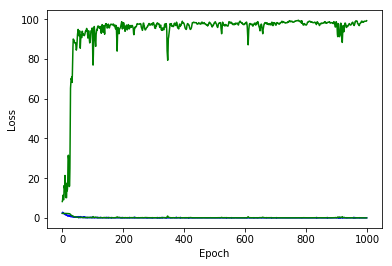

In [22]:
epoch_arr = range(1000)
train_loss = []
test_loss = []
max_test = 0

#Entrainement
for epoch in epoch_arr:
    train_loss.append( train(model, dataloader_train, optimizer, epoch, F.nll_loss))
    loss,test_prc = test(model, dataloader_test)
    if test_prc > max_test:
        max_test = test_prc
        torch.save(model.state_dict(), './best.pth')
    test_loss.append( loss )
print("max acc : ",max_test)
print("Used Seed: ", manualSeed)
#Affichage des courbes de loss
plt.plot(epoch_arr,train_loss,'b')
plt.plot(epoch_arr,test_loss,'g')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

On peut voir qu'avec cette architecture les résultats sont impressionnant et peuvent atteindre les 99%.

## Utilisation du réseau

Maintenant que nous avons un réseau foncitonnel il est temps de s'en servir !


In [ ]:
#Chargement du dernier meilleur model
model.load_state_dict(torch.load("./best.pth"))
def test_on(model,path):
    model.eval()
    #Normalisation de l'image
    Trans = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
            ])
    im = Image.open(path).convert('L').resize((32,32))
    #im.show()
    #Conversion en variable pytorhc
    im = torch.autograd.Variable(Trans(im).unsqueeze_(0))
    #Evaluation
    with torch.no_grad():
            im = im.to(device)
            output = model(im)
            print("Output : ",output)
            print("Output : ",output.argmax(dim=1, keepdim=True))
            
#Test sur une image
#Il suffit de changer le chemin pour essayer sur une image.
test_on(model,"./datas/eval/image_1.jpg")